In [1]:
import xarray as xr
import numpy as np
import cartopy
from cartopy import crs as ccrs
import matplotlib 
matplotlib.rcParams["font.size"] = 12
from matplotlib import pyplot as plt
from os.path import join, exists
from os import mkdir
import scipy
import netCDF4
import sklearn
import sys
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
%matplotlib inline
import matplotlib.path as mpath
import importlib.util
import MM_util_AI
import MM_utilplot
import warnings
import pickle

warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import shap
import tensorflow as tf
from sklearn.metrics import confusion_matrix,recall_score,precision_score
from scipy import stats

import os

spec = importlib.util.spec_from_file_location("MM_dataprepare", \
                        "/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/MM_dataprepare.py")
MM_dataprepare = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = MM_dataprepare
spec.loader.exec_module(MM_dataprepare)

spec = importlib.util.spec_from_file_location("MM_utilblocking", \
                        "/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/MM_utilblocking.py")
MM_utilblocking = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = MM_utilblocking
spec.loader.exec_module(MM_utilblocking)

 
            
with open("/scratch/hz1994/blocking/data_MMmodel/filepath.txt","r") as fi:
    for ln in fi:
        if ln.startswith("dimensionalized_filepath"):
            dim_path=ln.strip().split('\t')[1]
        if ln.startswith("nondimensionalized_filepath"):
            nondim_path=ln.strip().split('\t')[1]
        if ln.startswith("code_filepath"):
            code_path=ln.strip().split('\t')[1]            
        if ln.startswith("DGindex_filepath"):
            DGindex_path=ln.strip().split('\t')[1]  
        if ln.startswith("conditionedT_filepath" ):
            train_path=ln.strip().split('\t')[1]
        if ln.startswith("model_filepath" ):
            models_path=ln.strip().split('\t')[1]
        if ln.startswith("fig_filepath" ):
            fig_path=ln.strip().split('\t')[1] 
print(dim_path)
print(nondim_path)
print(code_path)
print(DGindex_path)
print(train_path)
print(models_path)
print(fig_path)
train_path_setA=train_path+'T/'
models_path_setA=models_path+'T/'

/ext3/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-07-31 18:18:39.553477: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:18:51.543906: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:18:51.543931: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:18:51.544394: 

/scratch/hz1994/blocking/data_MMmodel/dim/
/scratch/hz1994/blocking/data_MMmodel/nondim/
/scratch/hz1994/blocking/MMmodel/MMmodel/code_Lucarini/
/scratch/hz1994/blocking/data_MMmodel/DGindex/
/scratch/hz1994/blocking/data_MMmodel/conditionT/
/scratch/hz1994/blocking/data_MMmodel/CNNmodels/
/scratch/hz1994/blocking/data_MMmodel/fig_MMmodel/


In [2]:
import matplotlib.colors as colors
def polorplot(ax,data_xr,max_abs,levels):
    norm = colors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)
    im=xr.plot.contourf( 
        data_xr,
        x="longitude", y="latitude", ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm',\
        levels=levels, add_colorbar=False,norm=norm
    )
    gl=ax.gridlines(draw_labels=False)
    gl.ylocator = mticker.FixedLocator([20,40,60,80])  
    ax.coastlines(alpha=0.6)
    
    return ax,im


def polorplot_levels(plotmap,latitudes,longitudes ,minval,maxval, label, number_levels=30,iv=0.02):
    fig,ax = plt.subplots(figsize=(9,3), 
            subplot_kw={'projection': ccrs.NorthPolarStereo()},ncols=3)
    titles=["Z200","Z500","Z800"]
    max_abs=max(abs(minval),abs(maxval))
    print("min plotmap=", plotmap.min() ,"max plotmap=", plotmap.max() ,)
    ims=[]
    for i in range(3):
        y=plotmap[:,:,i]
        a = xr.DataArray(y, 
            coords={'latitude':latitudes,'longitude': longitudes,}, 
            dims=["latitude","longitude",])
        ax[i],im =polorplot( ax[i],a, max_abs=max_abs,\
                            levels=np.linspace(minval,maxval,number_levels))
        ax[i].set_title(titles[i])
        ims.append(im)
    cbar_ax = fig.add_axes([0.05, -0.1, .9, .05]) #left, bottom, width, height
    cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal",cmap='coolwarm',\
                        ticks= np.arange(iv*int(minval/iv),iv*int(maxval/iv)+iv,iv),\
                        label =label, shrink = 1,)
    print(np.arange(iv*int(minval/iv),iv*int(maxval/iv)+iv,iv))
    fig.tight_layout()
    return fig,ax,ims

    
def add_sq(sq,ax):
    if sq:
        path="/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/shap_values_list_epoch_%d/"%4
        color=["#000000", "#0072B2", "#009E73", "#D50000","#CC79A7"]
        boundary1_sq=np.load(path+"boundary1_sq.npy")
        boundary2_sq=np.load(path+"boundary2_sq.npy")
        boundary3_sq=np.load(path+"boundary3_sq.npy")
        boundary4_sq=np.load(path+"boundary4_sq.npy")
        for a in ax:
            a .plot(boundary1_sq[:,1],boundary1_sq[:,0],'-',color=color[0],alpha = 1,transform=ccrs.PlateCarree(),)
            a .plot(boundary2_sq[:,1],boundary2_sq[:,0],'-',color=color[1],alpha = 1,transform=ccrs.PlateCarree(),)
            a .plot(boundary3_sq[:,1],boundary3_sq[:,0],'-',color=color[2],alpha = 1,transform=ccrs.PlateCarree(),)
            a .plot(boundary4_sq[:,1],boundary4_sq[:,0],'-',color=color[3],alpha = 1,transform=ccrs.PlateCarree(),)
        return ax
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 16}
plt.rc('font', **font)
plt.rcParams['axes.linewidth'] = 1.5

import tensorflow as tf
from sklearn.metrics import confusion_matrix,recall_score,precision_score

# Compute the composite map and save

In [ ]:
Duration=5
X=np.load("/scratch/hz1994/blocking/data_era5/"+"test_data_1940-2022.npy")  
Ysparse=np.load("/scratch/hz1994/blocking/data_era5/"+"test_labels_1940-2022_T%d.npy"%Duration)
Y=np.zeros((Ysparse.size,2)).astype(bool)
Y[:,1][Ysparse==1]=True  #blocking
Y[:,0][Ysparse==0]=True
latitudes = np.load(dim_path+'dataX_lat.npy')
longitudes = np.load(dim_path+'dataX_lon.npy')
blocking_composite=X[Ysparse==1].mean(axis=0)
nonblocking_composite=X[Ysparse==0].mean(axis=0)
np.save("/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/blocking_composite_ERA5.npy", blocking_composite )

models_path="/scratch/hz1994/blocking/data_MMmodel/CNNmodels/"
train_path_setA=train_path+'T/'
models_path_setA=models_path+'T/'
X=np.load(train_path_setA+"/full/"+"data_X_T1_"+"1250k_lowpass3dys"+"_proc.npy")
Ysparse=np.load(train_path_setA+"/full/"+"data_Y_T1_"+"1250k_lowpass3dys"+".npy")
blocking_composite=X[Ysparse==1].mean(axis=0)
nonblocking_composite=X[Ysparse==0].mean(axis=0)
np.save("/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/blocking_composite_MM.npy", blocking_composite )


# Compute p-value for era5 and MM models and save

In [10]:
Duration=5
X=np.load("/scratch/hz1994/blocking/data_era5/"+"test_data_1940-2022.npy")  
Ysparse=np.load("/scratch/hz1994/blocking/data_era5/"+"test_labels_1940-2022_T%d.npy"%Duration)
latitudes = np.load(dim_path+'dataX_lat.npy')
longitudes = np.load(dim_path+'dataX_lon.npy') 
# Known population mean (e.g., long-term average temperature)
popmean = 0

# Create arrays to store t-statistics and p-values
t_statistics = np.zeros(X.shape[1:])
p_values = np.zeros(X.shape[1:])

X_block_events=X[Ysparse==1]
# Perform t-test for each grid point
print(X_block_events.shape)
for i in range(p_values.shape[0]): 
    for j in range(p_values.shape[1]):
        for k in range(p_values.shape[2]):
            t_statistics[i, j,k], p_values[i, j,k] = stats.ttest_1samp(X_block_events[:, i, j,k], popmean)
np.save("/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/blocking_ERA5_p_values.npy", p_values )



models_path="/scratch/hz1994/blocking/data_MMmodel/CNNmodels/"
train_path_setA=train_path+'T/'
models_path_setA=models_path+'T/'
X=np.load(train_path_setA+"/full/"+"data_X_T1_"+"1250k_lowpass3dys"+"_proc.npy")
Ysparse=np.load(train_path_setA+"/full/"+"data_Y_T1_"+"1250k_lowpass3dys"+".npy")  
X_block_events=X[Ysparse==1]
print(X_block_events.shape)
popmean = 0

# Create arrays to store t-statistics and p-values
t_statistics = np.zeros(X.shape[1:])
p_values = np.zeros(X.shape[1:])

# Perform t-test for each grid point
for i in range(p_values.shape[0]): 
    for j in range(p_values.shape[1]):
        for k in range(p_values.shape[2]):
            t_statistics[i, j,k], p_values[i, j,k] = stats.ttest_1samp(X_block_events[:, i, j,k], popmean)
np.save("/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/blocking_MM_p_values.npy", p_values )


(84, 18, 90, 3)


KeyboardInterrupt: 

# Plot the ERA5 composite

min plotmap= -0.4637488731046345 max plotmap= 0.4101069223509527
[-0.4 -0.2  0.   0.2  0.4]
[59.994269896446724, 63.86422566412007]


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


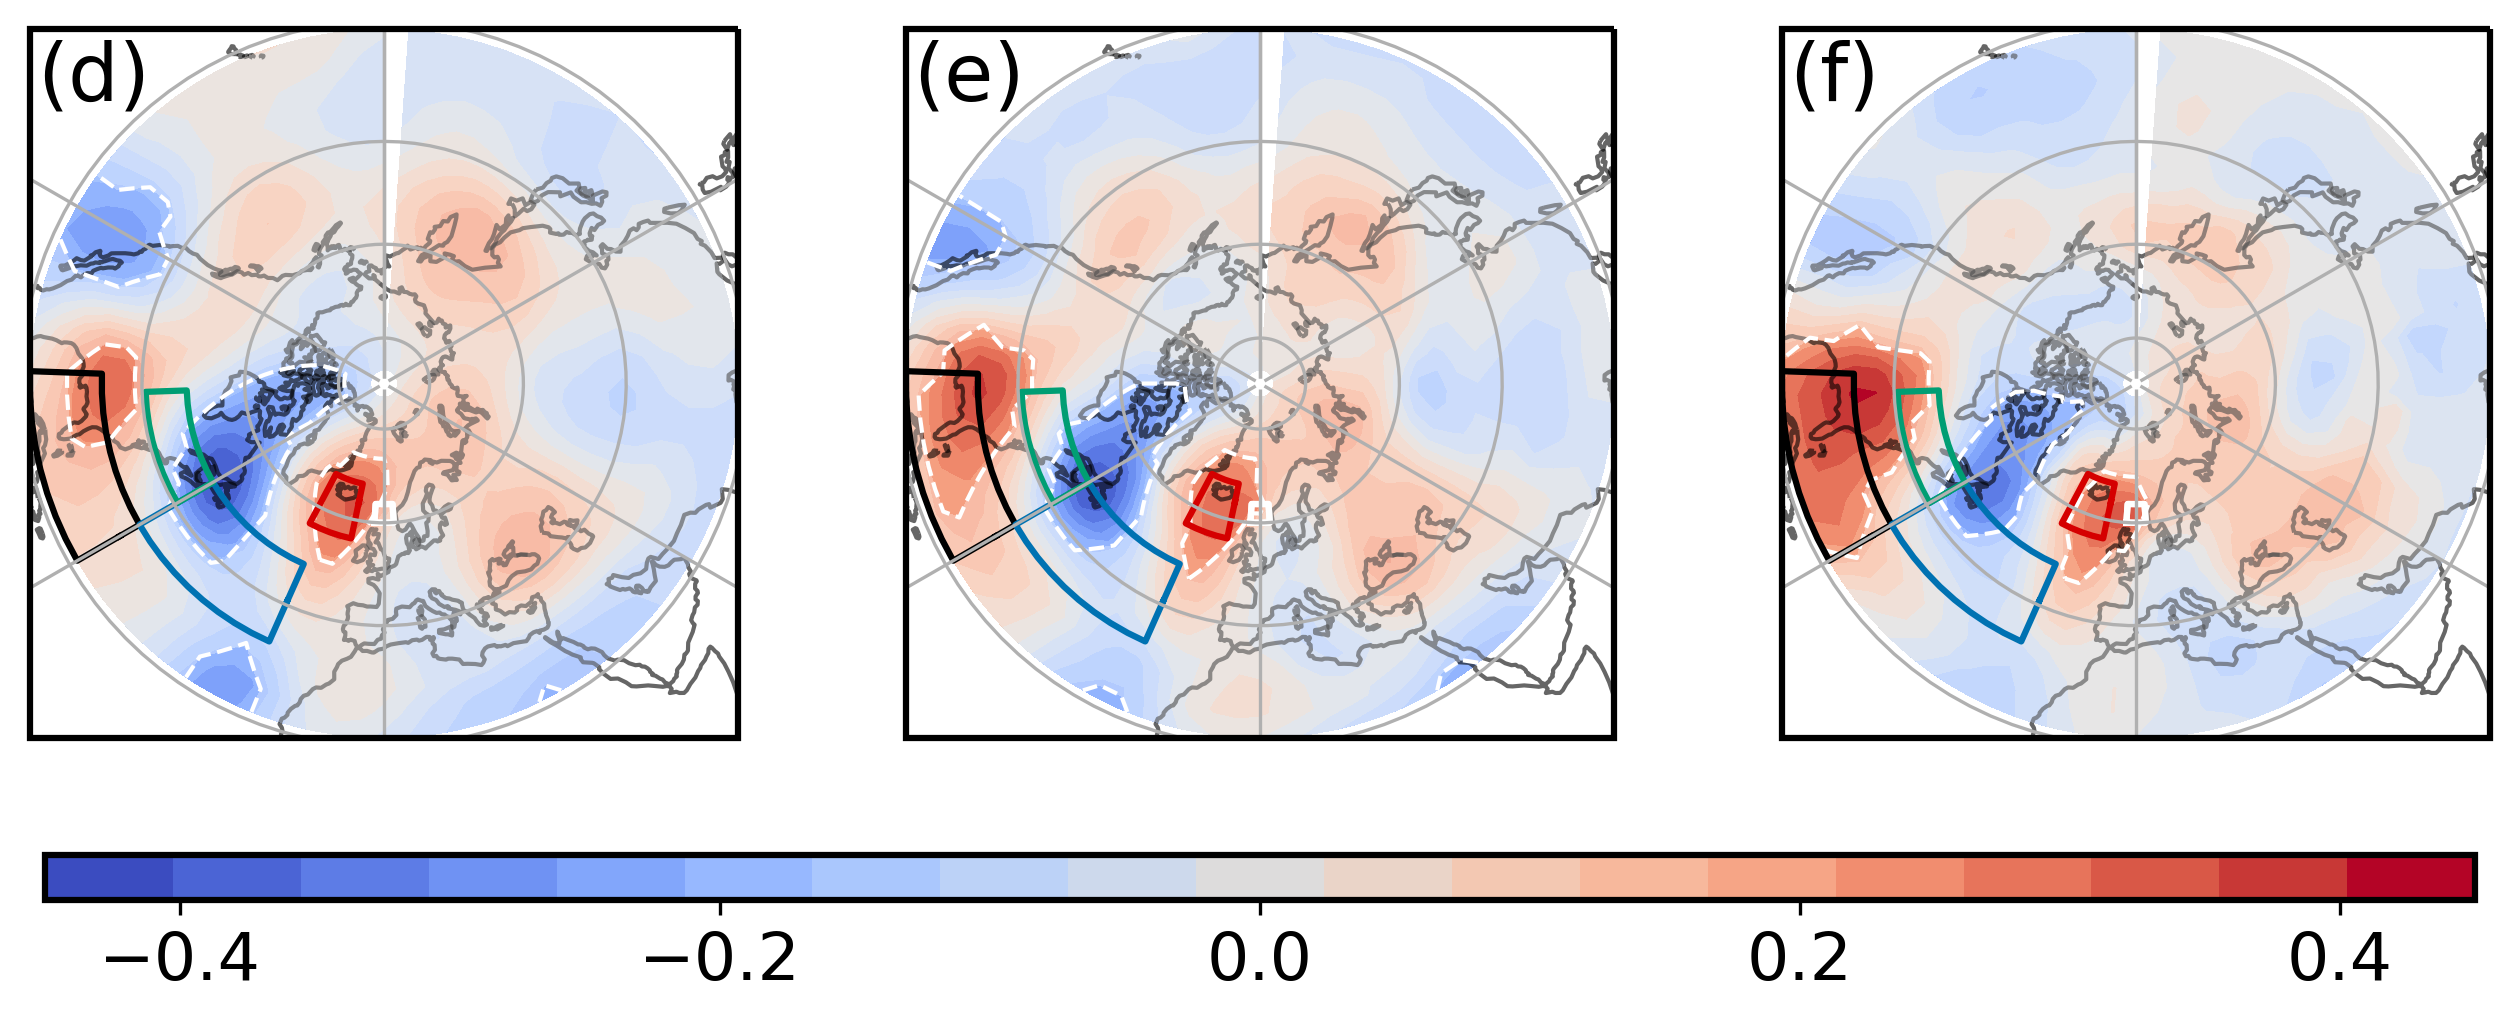

In [6]:
    
def significance (significance_mask, latitudes,longitudes,):
    for i in range(3):
        y=significance_mask[:,:,i]
        a = xr.DataArray(y, 
            coords={'latitude':latitudes,'longitude': longitudes,}, 
            dims=["latitude","longitude",])
        im=xr.plot.contour( 
            a,
            x="longitude", y="latitude", ax=ax[i],transform=ccrs.PlateCarree(),  colors='white', linestyles='dashed', linewidths=1,\
            levels=[0.5], add_colorbar=False 
        )
         
        # Define custom colors with RGBA
        custom_colors = [(1, 1, 1, 0.3),  # Semi-transparent white for <0.5
                         (1, 1, 1, 0)]    # Fully transparent for 0.5-1
        
        # Create the colormap
        cmap = ListedColormap(custom_colors)
        
        # Normalize the levels
        norm = BoundaryNorm([0, 0.5, 1], cmap.N)
        
        # Contour fill with the custom colormap
        shade = xr.plot.contourf(a, 
                                 x="longitude", 
                                 y="latitude", 
                                 ax=ax[i], 
                                 transform=ccrs.PlateCarree(), 
                                 cmap=cmap, 
                                 norm=norm,
                                 levels=[0, 0.5, 1], 
                                 add_colorbar=False)
        
    return fig,ax
    
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
blocking_composite_ERA5=np.load("/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/blocking_composite_ERA5.npy")
latitudes = np.load(dim_path+'dataX_lat.npy')
longitudes = np.load(dim_path+'dataX_lon.npy')
color=["#000000", "#0072B2", "#009E73", "#D50000","#CC79A7"] 
fig,ax,_=polorplot_levels(blocking_composite_ERA5,  latitudes,longitudes,\
                                minval=-0.45,maxval=0.45,label="", number_levels=20,iv=0.2)

p_values_ERA5=np.load("/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/blocking_ERA5_p_values.npy")

significance_mask = p_values_ERA5 < 0.05
fig,ax=significance (significance_mask, latitudes,longitudes,)

lon_atl=[]
lat_atl=[]
lat_atl=[latitudes[10],latitudes[10],latitudes[11],latitudes[11],latitudes[10]]
lon_atl=[longitudes[44],longitudes[46],longitudes[46],longitudes[44],longitudes[44]]

ax=ax.flatten()
for a in ax:
    a.plot(lon_atl, lat_atl,'w',linestyle='-',alpha = 1,transform=ccrs.PlateCarree(), label='atl')
sq=True
str_sq=sq*"_sq"
ax=add_sq(sq,ax)


lat_atl=[latitudes[10] ,latitudes[11] ]
lon_atl=[longitudes[44],longitudes[45],longitudes[46] ]
print(lat_atl)
line_lat=[lat_atl[0],lat_atl[0],lat_atl[0],lat_atl[1],lat_atl[1],lat_atl[1],lat_atl[0]]
line_lon=[lon_atl[0],lon_atl[1],lon_atl[2],lon_atl[2],lon_atl[1],lon_atl[0],lon_atl[0]]

ax[0].plot(line_lon, line_lat,'w-',alpha = 1,transform=ccrs.PlateCarree(), label='atl')
ax[1].plot(line_lon, line_lat,'w-',alpha = 1,transform=ccrs.PlateCarree(), label='atl')
ax[2].plot(line_lon, line_lat,'w-',alpha = 1,transform=ccrs.PlateCarree(), label='atl')
ax[0].text(0.01,0.9, "(d)", transform=ax[0].transAxes, fontsize="large")
ax[1].text(0.01,0.9, "(e)", transform=ax[1].transAxes,  fontsize="large")
ax[2].text(0.01,0.9, "(f)", transform=ax[2].transAxes,  fontsize="large")
fig.savefig("Fig6_ERA5_composite"+str_sq+'.png',dpi=300, bbox_inches = "tight")

# Plot the MM composite

min plotmap= -0.6237862133038564 max plotmap= 0.61239285383215
[-0.6 -0.4 -0.2  0.   0.2  0.4  0.6]
[59.994269896446724, 63.86422566412007]


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


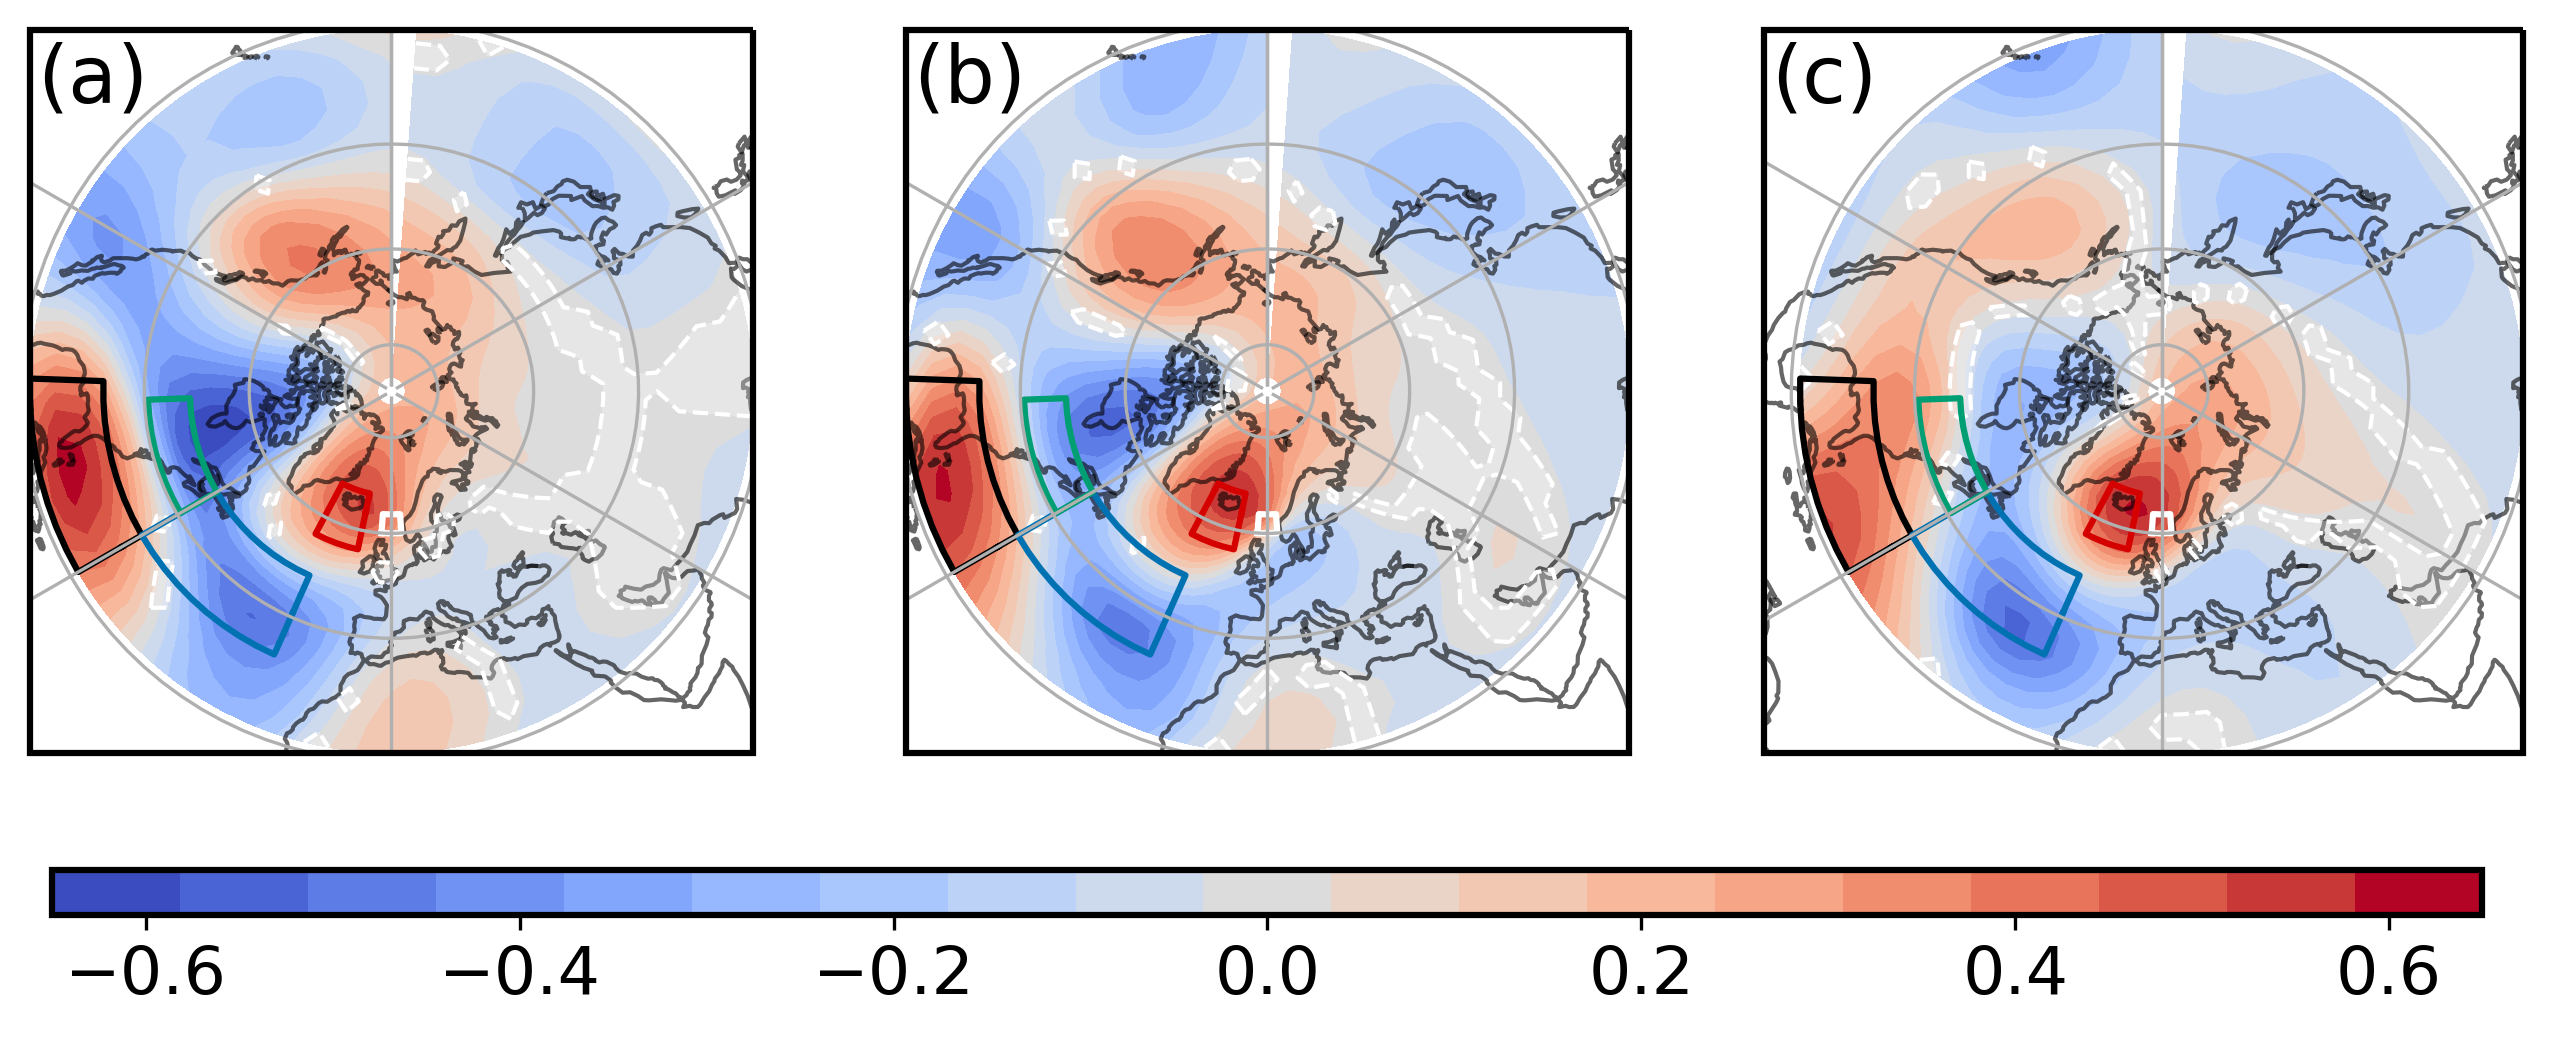

In [7]:
blocking_composite_MM=np.load("/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/blocking_composite_MM.npy")
fig,ax,_=polorplot_levels(blocking_composite_MM,latitudes,longitudes,\
                                minval=-0.65,maxval=0.65,label="",\
                          number_levels=20,iv=0.2)

p_values_MM=np.load("/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/blocking_MM_p_values.npy")
significance_mask = p_values_MM < 0.05
fig,ax=significance (significance_mask, latitudes,longitudes,)

sq=True
str_sq=sq*"_sq"
ax=add_sq(sq,ax)

lat_atl=[latitudes[10] ,latitudes[11] ]
lon_atl=[longitudes[44],longitudes[45],longitudes[46] ]
print(lat_atl)
line_lat=[lat_atl[0],lat_atl[0],lat_atl[0],lat_atl[1],lat_atl[1],lat_atl[1],lat_atl[0]]
line_lon=[lon_atl[0],lon_atl[1],lon_atl[2],lon_atl[2],lon_atl[1],lon_atl[0],lon_atl[0]]

ax[0].plot(line_lon, line_lat,'w-',alpha = 1,transform=ccrs.PlateCarree(), label='atl')
ax[1].plot(line_lon, line_lat,'w-',alpha = 1,transform=ccrs.PlateCarree(), label='atl')
ax[2].plot(line_lon, line_lat,'w-',alpha = 1,transform=ccrs.PlateCarree(), label='atl')
ax[0].text(0.01,0.9, "(a)", transform=ax[0].transAxes, fontsize="large")
ax[1].text(0.01,0.9, "(b)", transform=ax[1].transAxes,  fontsize="large")
ax[2].text(0.01,0.9, "(c)", transform=ax[2].transAxes,  fontsize="large")
fig.savefig("Fig6_MM_composite"+str_sq+'.png',dpi=300, bbox_inches = "tight")